In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

from time import time

# Question 4

**[80 points]** Recalling the presentation of FMM in 2D with the potential due to a charge as $\log(z)$, consider 3 clouds of points denoted as $S_1$ ,$S_2$ and $T_1$. The center of cloud $S_1$ in the complex plane is $−p$, the center for cloud $S_2$ is $p \, e^{-i \tfrac{\pi}{4}}$ and the center for $T_1$ is $p$, where $i^2=-1$. All clouds have $N$ points uniformly distributed within a circle of radius $r$ and the charges of $S_1$ and $S_2$ are uniformly distributed following uniform distribution $U(2,10)$.

---

**a)** Propose a numerical algorithm to perform a *fast* sum to evaluate the potential due the source points in cloud $S_1$ over the target points $T_1$ by means of a multipole expansion. The mathematical description of the source points can be written as:
$$
s_1(z) = \sum_{i=1}^N q_i \log(z-z_i).
$$

---

Asumiendo que las nubes no se tocan (para este ítem eso significa que $r < q$):

Se propone utilizar FFM colocando como orígen el centro de $S_1$. El potencial este sistema de coordenadas está entonces dado por:
$$
\phi(x) = \sum_{i=1}^{N} q_i \log(x-z_i') \,,
$$
donde $z_i' = z_i+p$.

Usando FFM este campo es equivalente a:
$$
\phi(x) \approx Q \log(x) + \sum_{k=1}^{P} \frac{a_k}{x^k} \,,
$$
donde
$$
Q = \sum_{i=1}^{N} q_i \qquad \qquad
a_k = \sum_{i=1}^{N} \frac{-q_i (z_i')^{k}}{k} \,.
$$
La aproximación es exacta cuando $P \rightarrow \infty$, pero se pueden calcular menos iteraciones.

Precomputando los $a_k$, que no dependen de $x$, sólo se necesitarían realizar $O(P)$ operaciones por cada uno de los $N$ puntos que se quieren evaluar en el campo. La complejidad final es entonces $O(N P)$, mejor que la $O(N^2)$ original.

Para obtener $s_i(z)$ se hace:
$$
s_i(z) = \phi(z+p)
$$

---

**b)** Implement in a Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as $N$ increases, show how the error changes and test how the approximation depends on $p$ and $r$.

*Hint: I suggest to keep $r = 1$ and only vary $p$ conveniently. Notice that if $p$ is large enough, the approximation should be good so it would be interesting to see what happens when the clouds approach each other!*

*Hint 2: An error vs computation time plot would be good.*

---

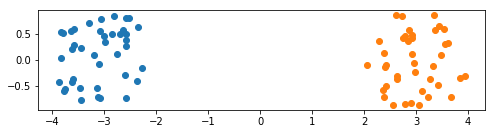

In [2]:
def point_cloud(N,rad=1):
    angles = 2*np.pi*np.random.random(N)
    poss = np.random.random(N)**0.5*rad*np.exp(1j*angles)
    return poss

def charges(N,minc,maxc):
    return minc+np.random.random(N)*(maxc-minc)

# Generate and plot points for a given p and N
def run_4b_1(): # just so the variables aren't created on global scope.
    p = 3
    N = 40
    pts_s1 = point_cloud(N)-p
    pts_t = point_cloud(N)+p
    pts_s1_q = charges(N,2,10)

    plt.figure(figsize=(8,6))
    plt.plot(np.real(pts_s1),np.imag(pts_s1),'o')
    plt.plot(np.real(pts_t),np.imag(pts_t),'o')
    plt.axis('scaled')
    plt.show()

run_4b_1()

In [3]:
# Compute the potential using the direct method
def direct_potential(srcs,srcs_q,trgts):
    fields = np.zeros(trgts.size)+0j
    for i in range(len(trgts)):
        t = trgts[i]
        deltas = t-srcs
        fields[i] = np.sum(np.log(deltas+0j)*srcs_q)
    return fields

# Compute the potential using fast multipole method
def fmm_potential(srcs,srcs_q,trgts,p=6):
    # sum of chargues
    qq = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # compute the z^k for each target:
    zk = np.expand_dims(trgts,-1)**np.arange(1,p+1)
    # get the fields for each target
    zs = qq*np.log(trgts+0j) + np.sum(aks/zk,axis=1)
    return zs

In [4]:
def compute_approx_errors_and_time(N,p,P_values,n_tests=10):

    real_times = []
    fmm_times = []
    fmm_errors = []

    # Compute metrics for several tests
    for n in range(n_tests):
        fmm_times.append([])
        fmm_errors.append([])

        pts_s1 = point_cloud(N)-p
        pts_t = point_cloud(N)+p
        pts_s1_q = charges(N,2,10)

        # compute right potential
        start = time()
        real_field = direct_potential(pts_s1,pts_s1_q,pts_t)
        real_times.append(time()-start)

        # compute approximation for fmm increasing the number of terms
        for P in P_values:
            start = time()
            fmm_field = fmm_potential(pts_s1+p,pts_s1_q,pts_t+p,P) # note relativization
            fmm_times[-1].append(time()-start)

            # compute mean relative error
            error = np.abs(fmm_field-real_field)/np.abs(real_field)
            error = np.mean(error)
            fmm_errors[-1].append(error)

    # mean of errors and times over tests
    fmm_errors = np.mean(fmm_errors,axis=0)
    fmm_times = np.mean(fmm_times,axis=0)
    real_times = np.mean(real_times,axis=0)

    return fmm_errors, fmm_times, real_times

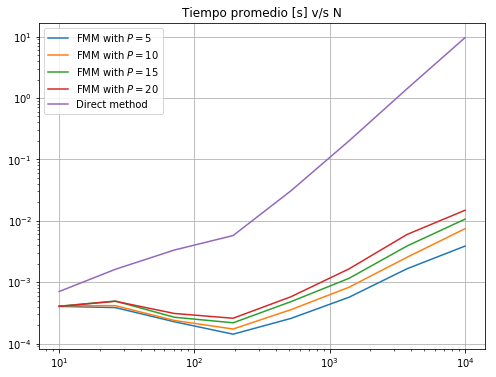

In [5]:
def mean_times_vs_n(computation):    
    
    # --- Times depend on N and P
    P_values = range(5,21,5)
    n_values = np.logspace(1,4,8).astype('int')
    real_ts = []
    fmm_ts = []
    for nn in n_values:
        # print("Computing for n=%d"%(nn))
        _, fmm_t, real_t = computation(nn,4.0,P_values=P_values)
        real_ts.append(real_t)
        fmm_ts.append(fmm_t)
    real_ts = np.array(real_ts)
    fmm_ts = np.array(fmm_ts)
    
    plt.figure(figsize=(8,6))
    for i in range(len(P_values)):
        plt.plot(n_values,fmm_ts[:,i],label="FMM with $P{=}%d$"%P_values[i])
    plt.plot(n_values,real_ts,label="Direct method")
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Tiempo promedio [s] v/s N")
    plt.legend()
    plt.grid()
    plt.show()
        
mean_times_vs_n(compute_approx_errors_and_time)

Se puede ver que conforme $N$ aumenta, el tiempo requerido para el método directo aumenta considerablemente, mientras que para FMM crece bastante lento, aumentar $P$ sólo aumenta el tiempo en un factor. 

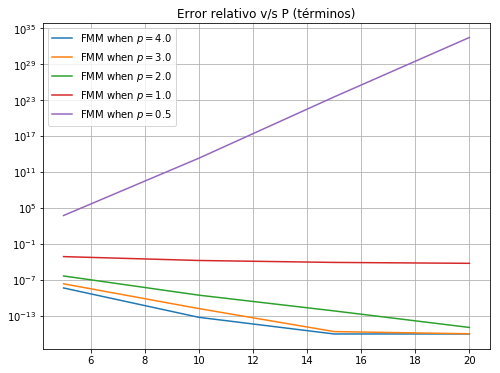

In [6]:
def rel_error_vs_P(computation):    
    
    # --- Errors depend on p (distance) and P (terms)
    P_values = range(5,21,5)
    N = 1000
    errors_ts = []
    p_values = [4.0,3.0,2.0,1.0,0.5]
    for pp in p_values:
        error_t,_,_ = computation(N,pp,P_values=P_values)
        errors_ts.append(error_t)
    fmm_ts = np.array(error_t)
    
    plt.figure(figsize=(8,6))
    for i in range(len(p_values)):
        plt.plot(P_values,errors_ts[i],label="FMM when $p{=}%.1f$"%p_values[i])
    plt.title("Error relativo v/s P (términos)")
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.show()
        
rel_error_vs_P(compute_approx_errors_and_time)

Usando $r=1$, se puede ver que cuando $p<1$ el error aumenta con más términos (mayor $P$). Cuando $p=1$ se mantiene constante (las nubes se tocan) y cuando $p>1$ converge, más rápido mientras mayor sea $p$.

---

**c)** Propose a numerical algorithm to perform a fast sum to evaluate the potential due the source points in cloud $S_1$ and $S_2$ over the target points $T_1$ by means of going from two multipole expansion to a power series.

---

Para cada una de las nubes de cargas:
* Se obtienen los coeficientes $a_i$ considerando como origen el centro de la nube.
* Se obtienen los coeficientes $b_l$ de la serie de potencias, moviendo el sistema de coordenadas de manera que el orígen es el centro de la nube $T_1$, resultando en la expresión:
$$
\phi(z)^{(i)} \approx \sum_{l=0}^Q {b_l^{(i)}} (z-p)^l
$$
para la nube $S_i$, donde los $b_l^{(i)}$ se calculan como:
$$
b_0^{(i)} = \sum_{k=1}^{P} \frac{a_k^{(i)}}{(z_0^{(i)}-p)^k} (-1)^k + a_0^{(i)} \log(-z_0^{(i)}+p)
$$
$$
b_l^{(i)} = \left( \frac{1}{(z_0^{(i)}-p)^l} \sum_{k=1}^{Q} \frac{a_k^{(i)}}{(z_0^{(i)}-p)^k} \binom{l+k-1}{k-1} (-1)^k \right) - \frac{a_0}{l (z_0^{(i)}-p)^l}
$$
donde $z_0^{(i)}$ es el centro de la nube $S_i$.

Finalmente se aproxima el campo para los puntos cerca de $T_1$ como:
$$
\phi(z) = \sum_{l=0}^Q (b_l^{(1)}+b_l^{(2)}) (z-p)^l
$$
donde $T = p$ es el centro de la nube $T_1$.

---

**d)** Implement in Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as N
increases. Also test how the approximation depends on ρ and r. Hint: Same hints from (b) are valid here.

---

In [7]:
# Compute the local taylor series coefficients for targets near the origin,
# where z0 is the center of the sources
def local_taylor_series_coefs(z0,srcs,srcs_q,p=6,q=6):
    # relativize sources to their center
    srcs -= z0
    # sum of chargues
    a0 = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # ---
    # compute the z0^k 's:
    z0k_p = z0**np.arange(1,p+1)
    z0k_q = z0**np.arange(1,q+1)
    # binomial coefficients for b_l. NOTE: this could be optimized using dynamic prog.
    binoms = [[binom(l+k-1,k-1) for k in range(1,p+1)] for l in range(1,q+1)]
    binoms = np.array(binoms)
    # compute b_l's
    b0 = np.sum(aks/z0k_p*(-1)**np.arange(1,p+1))+a0*np.log(-z0)
    bls = (1/z0k_q)*np.sum(aks/z0k_p*binoms*(-1)**np.arange(1,p+1),axis=1)
    bls -= a0/(np.arange(1,q+1)*z0k_q)
    return np.concatenate( ([b0],bls) )
    
def eval_coefs(coefs,trgts):
    # compute the z^k for each target:
    qp1 = np.shape(coefs)[0]
    zk = np.expand_dims(trgts,-1)**np.arange(qp1)
    # multiply the coefficients and sum
    return np.sum(zk*coefs,axis=1)

In [8]:
def compute_approx_errors_and_time_2(N,p,P_values,n_tests=10):
    
    real_times = []
    fmm_times = []
    fmm_errors = []

    # Compute metrics for several tests
    for n in range(n_tests):
        fmm_times.append([])
        fmm_errors.append([])

        z01 = -p
        z02 = p*np.exp(np.pi/4*1j)
        z0t = p
        pts_s1 = point_cloud(N)+z01
        pts_s2 = point_cloud(N)+z02
        pts_t = point_cloud(N)+z0t
        pts_s1_q = charges(N,2,10)
        pts_s2_q = charges(N,2,10)

        # compute right potential
        start = time()
        real_field = direct_potential(pts_s1,pts_s1_q,pts_t)
        real_field += direct_potential(pts_s2,pts_s2_q,pts_t)
        real_times.append(time()-start)

        # compute approximation for fmm increasing the number of terms
        for P in P_values:
            start = time()
            # Get series expansion coefficients from both source clouds and add them
            coefs = local_taylor_series_coefs(z01-z0t,pts_s1-z0t,pts_s1_q,p=P,q=P)
            coefs += local_taylor_series_coefs(z02-z0t,pts_s2-z0t,pts_s2_q,p=P,q=P)
                                                  # Note than we are making p=q=P
            # Evaluate coefficients
            fmm_field = eval_coefs(coefs,pts_t-z0t)
            
            fmm_times[-1].append(time()-start)
            # compute mean relative error
            error = np.abs(fmm_field-real_field)/np.abs(real_field)
            error = np.mean(error)
            fmm_errors[-1].append(error)

    # mean of errors and times over tests
    fmm_errors = np.mean(fmm_errors,axis=0)
    fmm_times = np.mean(fmm_times,axis=0)
    real_times = np.mean(real_times,axis=0)

    return fmm_errors, fmm_times, real_times

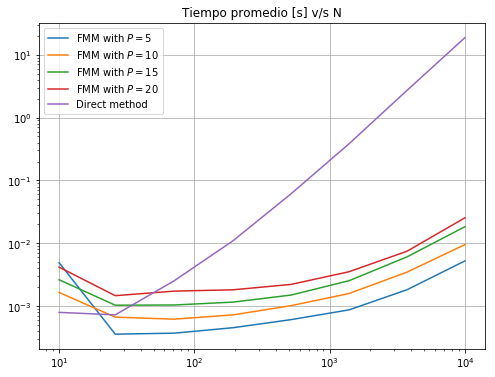

In [9]:
mean_times_vs_n(compute_approx_errors_and_time_2)

De este gráfico podemos obtener las mismas conclusiones para los tiempos que en 4.b, sólo que aquí se están usando las series de Taylor locales. 

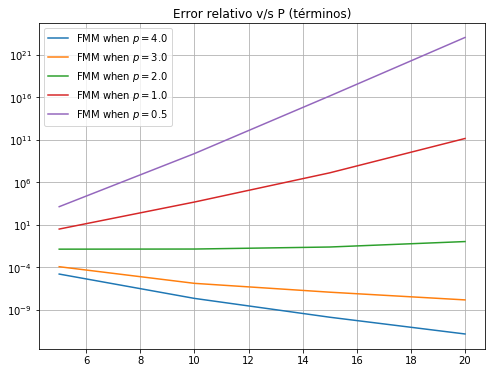

In [10]:
rel_error_vs_P(compute_approx_errors_and_time_2)

Si notamos que geometricamente la distancia entre el centro de $S_2$ y $T_1$ es
$$
p\sqrt{ \left(1-\frac{1}{\sqrt{2}}\right)^2 + \left(\frac{1}{\sqrt{2}}\right)^2} \approx 0.7654 p
$$
Podemos ver que se requiere una distancia mayor que $p=2.0$ para que el error converja (se requiere una separación mayor que $2r=2$).

Vale la pena notar que se necesitan valores más grandes de $P$ o $Q$ para lograr una buena aproximación.